# Market Timing Strategy Analysis Using Moving Averages

## Introduction

In this notebook, we will analyze a market timing strategy based on 10-month and 200-day Simple Moving Averages (SMAs). The primary objective is to compare the performance of these strategies against a traditional Buy and Hold approach. To ensure a fair comparison, we will normalize the volatility of the market timing strategies to match that of the Buy and Hold strategy. This analysis involves downloading historical financial data, calculating moving averages, generating buy/sell signals, mapping these signals to daily data, and visualizing the results.

---

## 1. Importing Necessary Libraries

First, we need to import the essential Python libraries required for data manipulation, analysis, and visualization.


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


## 2. Downloading Historical Data

We will download historical daily data for the ACWI (All Country World Index) using the `yfinance` library. The data will cover the maximum available period with a daily interval.


In [17]:
# Download historical data for ACWI
symbol = "ACWI"

df = yf.download(symbol, period="max", interval="1d")

# Resample the data to get monthly closing prices
dfm = df.resample('ME').last()

[*********************100%***********************]  1 of 1 completed



**Explanation:**

- **Data Download:**
  - **Ticker:** "ACWI" represents the All Country World Index.
  - **Period:** `"max"` downloads the maximum available historical data.
  - **Interval:** `"1d"` specifies daily data.

- **Resampling:**
  - Converts daily data to monthly data by taking the last trading day of each month (`'ME'` stands for Month-End frequency).




---

## 3. Calculating Moving Averages and Generating Signals

We calculate the 10-month moving average for the monthly data and the 200-day moving average for the daily data. Based on these moving averages, we generate buy and sell signals.


In [21]:
# Calculate the 10 Month Moving Average for the monthly data
dfm["10_Month_Moving_Average"] = dfm['Close'].rolling(window=10).mean()

# Calculate the 200 Day Moving Average for the daily data
df["200_Day_Moving_Average"] = df['Close'].rolling(window=200).mean()

# Create Signals in the DataFrames: Buy=1 if the price is higher than the moving average, Sell=0 otherwise
dfm["Signal"] = 0
dfm.loc[dfm["Close"] > dfm["10_Month_Moving_Average"], "Signal"] = 1
df["200D_Signal"] = 0
df.loc[df["Close"] > df["200_Day_Moving_Average"], "200D_Signal"] = 1


**Explanation:**

- **Moving Averages:**
  - **10-Month SMA (`dfm`):** Calculates the rolling mean of the closing prices over a 10-month window.
  - **200-Day SMA (`df`):** Calculates the rolling mean of the closing prices over a 200-day window.

- **Generating Signals:**
  - **Signal Creation:**
    - **Buy Signal (`1`):** When the closing price is above the respective moving average.
    - **Sell Signal (`0`):** When the closing price is below the respective moving average.

---

## 4. Mapping Monthly Signals to Daily Data

Since the buy/sell signals are generated on a monthly basis, we need to map these signals to the corresponding daily data to apply the strategy on a daily trading schedule.


In [22]:

df["Signal"] = 0
for i in range(len(df)):
    current_date = df.index[i]
    prev_month_end = current_date - pd.offsets.MonthEnd(1)
    try:
        signal = dfm.loc[prev_month_end, "Signal"]
        df.loc[current_date, "Signal"] = signal
    except KeyError:
        pass


**Explanation:**

- **Signal Mapping:**
  - Iterates through each day in the daily DataFrame (`df`).
  - For each day, identifies the previous month's end date.
  - Retrieves the corresponding monthly signal and assigns it to the daily data.
  - If the previous month's end date does not exist in the monthly DataFrame (`dfm`), it skips assigning a signal.

---

## 5. Identifying the First Buy Signal and Slicing Data

We identify the first occurrence of a buy signal and create a slice of the data around this event for further analysis.


In [7]:
# Find the first occurrence of Signal turning to 1
first_signal_1 = dfm[dfm['Signal'] == 1].index[0]

# Get the index of 2 rows before and after the first signal
start_index = max(0, dfm.index.get_loc(first_signal_1) - 2)
end_index = min(len(dfm), dfm.index.get_loc(first_signal_1) + 3)

# Slice the DataFrame to show 5 rows before and after the first signal
dfm_slice = dfm.iloc[start_index:end_index]
dfm_slice

,Open,High,Low,Close,Adj Close,Volume,10_Month_Moving_Average,Signal
Date,,,,,,,,
2009-03-31,28.230000,28.719999,28.049999,28.330000,20.684328,326100,36.548,0
2009-04-30,32.230000,32.419998,31.730000,31.950001,23.327368,415000,34.801,0
2009-05-31,35.090000,35.299999,34.790001,35.299999,25.773277,89900,33.545,1
2009-06-30,34.939999,34.939999,34.290001,34.490002,25.382101,157400,32.288,1
2009-07-31,37.799999,37.980000,37.480000,37.740002,27.773865,229700,31.933,1


In [11]:
# First Buy Signal was 2009-05-31
# Let's check our Dataframe with daily data to see if the mapping worked 
# and the first buy signal was on the next trading day.
df[df.index >= pd.Timestamp('2009-05-31') - pd.Timedelta(days=3)][:5]

,Open,High,Low,Close,Adj Close,Volume,200_Day_Moving_Average,200D_Signal,Signal
Date,,,,,,,,,
2009-05-28,34.400002,34.750000,34.080002,34.619999,25.276789,177400,33.19360,1,0
2009-05-29,35.090000,35.299999,34.790001,35.299999,25.773277,89900,33.13295,1,0
2009-06-01,36.070000,36.330002,35.900002,36.110001,26.364674,211100,33.07750,1,1
2009-06-02,36.189999,36.360001,35.950001,36.139999,26.386578,154600,33.02200,1,1
2009-06-03,35.889999,35.889999,35.090000,35.439999,25.875496,133000,32.96395,1,1



**Explanation:**

- **Verification:**
  - Extracts daily data starting from two days before the first buy signal date (`2009-05-31`).
  - This helps verify if the buy signal is correctly mapped to the subsequent trading days.



In [24]:
# Calculate the daily returns for the buy-and-hold strategy
df["Buy&Hold_Returns"] = df["Close"].pct_change().fillna(0)

# Calculate the daily returns for the market timing strategy
df["MarketTiming_10Month"] = df["Signal"].shift(1) * df["Close"].pct_change().fillna(0)
df["MarketTiming_200Day"] = df["200D_Signal"].shift(1) * df["Close"].pct_change().fillna(0)

# Calculate the cumulative returns for both strategies
df["Buy&Hold_Cumulative_Returns"] = (1 + df["Buy&Hold_Returns"]).cumprod()
df["MarketTiming_10Month_Cumulative_Returns"] = (1 + df["MarketTiming_10Month"]).cumprod()
df["MarketTiming_200Day_Cumulative_Returns"] = (1 + df["MarketTiming_200Day"]).cumprod()

In [25]:
# Calculate the annualized returns and volatility for both strategies
total_months = len(dfm)
buy_and_hold_annualized_returns = (df["Buy&Hold_Cumulative_Returns"].iloc[-1])**(12/total_months) - 1
market_timing_10M_annualized_returns = (df["MarketTiming_10Month_Cumulative_Returns"].iloc[-1])**(12/total_months) - 1
market_timing_200D_annualized_returns = (df["MarketTiming_200Day_Cumulative_Returns"].iloc[-1])**(12/total_months) - 1

buy_and_hold_annualized_volatility = df["Buy&Hold_Returns"].std() * (252 ** 0.5)
market_timing_10M_annualized_volatility = df["MarketTiming_10Month"].std() * (252 ** 0.5)
market_timing_200D_annualized_volatility = df["MarketTiming_200Day"].std() * (252 ** 0.5)

# Calculate the Sharpe ratio for both strategies
buy_and_hold_sharpe_ratio = buy_and_hold_annualized_returns / buy_and_hold_annualized_volatility
market_timing_10M_sharpe_ratio = market_timing_10M_annualized_returns / market_timing_10M_annualized_volatility
market_timing_200D_sharpe_ratio = market_timing_200D_annualized_returns / market_timing_200D_annualized_volatility

# Print the results
print(f"Buy and Hold Annualized Returns: {buy_and_hold_annualized_returns:.3f}")
print(f"Market Timing (10M SMA) Annualized Returns: {market_timing_10M_annualized_returns:.3f}")
print(f"Market Timing (200D SMA) Annualized Returns: {market_timing_200D_annualized_returns:.3f}")

print(f"\nBuy and Hold Annualized Volatility: {buy_and_hold_annualized_volatility:.3f}")
print(f"Market Timing (10M SMA) Annualized Volatility: {market_timing_10M_annualized_volatility:.3f}")
print(f"Market Timing (200D SMA) Annualized Volatility: {market_timing_200D_annualized_volatility:.3f}")

print("\nBuy and Hold Sharpe Ratio:", f"{buy_and_hold_sharpe_ratio:.2f}")
print("Market Timing 10-Month SMA Sharpe Ratio:", f"{market_timing_10M_sharpe_ratio:.2f}")
print("Market Timing 200-Day SMA Sharpe Ratio:", f"{market_timing_200D_sharpe_ratio:.2f}")

Buy and Hold Annualized Returns: 0.052
Market Timing (10M SMA) Annualized Returns: 0.048
Market Timing (200D SMA) Annualized Returns: 0.041

Buy and Hold Annualized Volatility: 0.206
Market Timing (10M SMA) Annualized Volatility: 0.115
Market Timing (200D SMA) Annualized Volatility: 0.113

Buy and Hold Sharpe Ratio: 0.25
Market Timing 10-Month SMA Sharpe Ratio: 0.42
Market Timing 200-Day SMA Sharpe Ratio: 0.36


In [28]:
# Function to Calculate Drawdowns
def calculate_drawdowns(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown

# Calculating Drawdowns
df['BuyHold_Drawdown'] = calculate_drawdowns(df['Buy&Hold_Cumulative_Returns'])
df['MT10M_Drawdown'] = calculate_drawdowns(df['MarketTiming_10Month_Cumulative_Returns'])
df['MT200D_Drawdown'] = calculate_drawdowns(df['MarketTiming_200Day_Cumulative_Returns'])

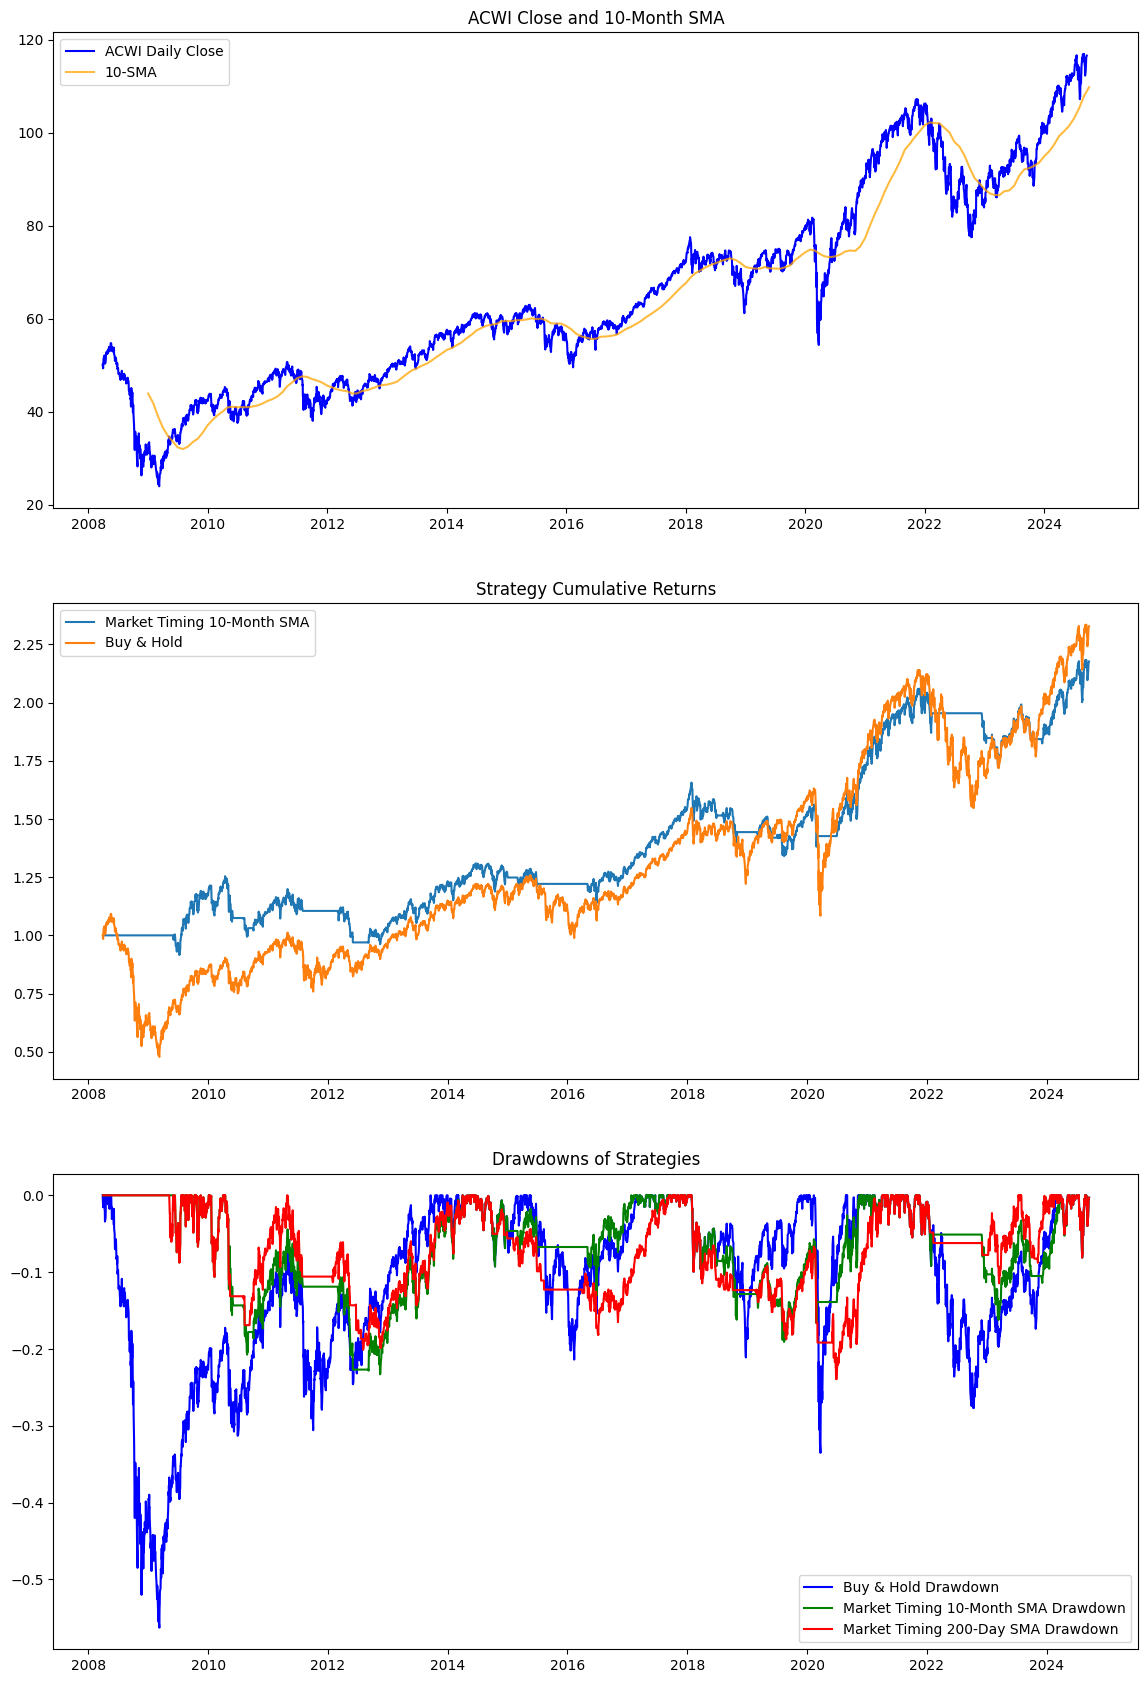

In [35]:
# Plotting the results
plt.figure(figsize=(14, 21))  # Increased figure height to accommodate 3 subplots
plt.subplot(311)
plt.plot(df['Close'], label=f'{symbol} Daily Close', color='blue')
plt.plot(dfm['10_Month_Moving_Average'], label='10-SMA', color='orange', alpha=0.75)
plt.title('ACWI Close and 10-Month SMA')
plt.legend()

plt.subplot(312)
plt.plot(df['MarketTiming_10Month_Cumulative_Returns'], label='Market Timing 10-Month SMA')
plt.plot(df['Buy&Hold_Cumulative_Returns'], label='Buy & Hold')
plt.title('Strategy Cumulative Returns')
plt.legend()

plt.subplot(313)
plt.plot(df['BuyHold_Drawdown'], label='Buy & Hold Drawdown', color='blue')
plt.plot(df['MT10M_Drawdown'], label='Market Timing 10-Month SMA Drawdown', color='green')
plt.plot(df['MT200D_Drawdown'], label='Market Timing 200-Day SMA Drawdown', color='red')
plt.title('Drawdowns of Strategies')
plt.legend()

plt.show()